In [1]:
!pip install bz2file

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from sklearn.preprocessing import LabelBinarizer as LB
from sklearn.preprocessing import normalize 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
# --------------------
from keras.layers.convolutional import Conv2D, ZeroPadding2D
from keras.layers.core import Reshape, Flatten, Dropout
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras import metrics
# --------------------
from pandas import DataFrame as df
# --------------------
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
# --------------------
import tarfile
import pickle
import random
import keras
import sys
import gc
import bz2file as bz2
import pickle

from keras.layers import Input,Lambda,Dense,Flatten,Conv2D,MaxPooling2D
from keras.models import Model,Sequential
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

!tar -xvf /content/drive/MyDrive/RML2016.10b.bz2 -C /content/drive/MyDrive/

RML2016.10b.dat
LICENSE.TXT


In [4]:
file = open("/content/drive/MyDrive/RML2016.10b.dat",'rb')
Xd = pickle.load(file, encoding = 'bytes')
snrs, mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = [] 
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)
file.close()

## Create Features Space

In [5]:
features = {}

**Raw Time Feature**

In [6]:
features['raw']        = X[:,0], X[:,1]

**First derivative in time**

In [7]:
features['derivative'] = normalize(np.gradient(X[:,0], axis = 1)), normalize(np.gradient(X[:,1], axis = 1))

**Integral in time**

In [8]:
features['integral']   = normalize(np.cumsum(X[:,0], axis = 1)), normalize(np.cumsum(X[:,1], axis = 1))

**All Togetheer Feature Space**

In [9]:
def extract_features(*arguments):
    
    desired = ()            
    for arg in arguments:
        desired += features[arg]
    
    return np.stack(desired, axis = 1)

## Train and Test Data Split

** features Choice **

In [10]:
data = extract_features('raw')
labels = np.array(lbl)

In [11]:
in_shape = data[0].shape
out_shape = tuple([1]) + in_shape

** data shuffling & splitting **

In [12]:
np.random.seed(10)

n_examples = labels.shape[0]

r = np.random.choice(range(n_examples), n_examples, replace = False)

train_examples = r[:n_examples//2]
test_examples =  r[n_examples//2:]

In [13]:
X_train = data[train_examples]
X_test = data[test_examples]

y_train = LB().fit_transform(labels[train_examples][:,0])
y_test = LB().fit_transform(labels[test_examples][:,0])

snr_train = labels[train_examples][:,1].astype(int)
snr_test = labels[test_examples][:,1].astype(int)

## Model for CNN New


In [14]:
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=in_shape))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))

In [15]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',  metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2, 128)            16512     
                                                                 
 dense_1 (Dense)             (None, 2, 256)            33024     
                                                                 
 dense_2 (Dense)             (None, 2, 128)            32896     
                                                                 
 dense_3 (Dense)             (None, 2, 64)             8256      
                                                                 
 dense_4 (Dense)             (None, 2, 32)             2080      
                                                                 
 dense_5 (Dense)             (None, 2, 16)             528       
                                                                 
 flatten (Flatten)           (None, 32)                0

In [16]:
model.fit(X_train, y_train, epochs = 150, validation_split = 0.05, batch_size = 2048, callbacks=[EarlyStopping(patience = 15, restore_best_weights = True)])

Epoch 1/150
279/279 [==============================] - 21s 68ms/step - loss: 1.9617 - accuracy: 0.2298 - val_loss: 1.6982 - val_accuracy: 0.3221
Epoch 2/150
279/279 [==============================] - 20s 72ms/step - loss: 1.6110 - accuracy: 0.3448 - val_loss: 1.5281 - val_accuracy: 0.3700
Epoch 3/150
279/279 [==============================] - 20s 72ms/step - loss: 1.5299 - accuracy: 0.3740 - val_loss: 1.4987 - val_accuracy: 0.3887
Epoch 4/150
279/279 [==============================] - 18s 65ms/step - loss: 1.5060 - accuracy: 0.3852 - val_loss: 1.4984 - val_accuracy: 0.3889
Epoch 5/150
279/279 [==============================] - 20s 72ms/step - loss: 1.4938 - accuracy: 0.3905 - val_loss: 1.4725 - val_accuracy: 0.4013
Epoch 6/150
279/279 [==============================] - 19s 67ms/step - loss: 1.4812 - accuracy: 0.3954 - val_loss: 1.4646 - val_accuracy: 0.4030
Epoch 7/150
279/279 [==============================] - 18s 65ms/step - loss: 1.4722 - accuracy: 0.4000 - val_loss: 1.4567 - val_ac

In [17]:
model.save('/content/drive/MyDrive/ann_new_version.h5')

## Evaluation

In [18]:
def plot_results(predicted_labels, true_labels, snrs):
  
  sorted_snrs = np.sort(np.unique(snrs))
  
  x_axis = []
  y_axis = []
  for snr in sorted_snrs:
    idx = np.where(snrs == snr)
    #print('snr =', snr, '-->', accuracy_score(np.argmax(true_labels[idx], axis = 1), np.argmax(predicted_labels[idx], axis = 1)))
    x_axis.append(snr)
    y_axis.append(accuracy_score(np.argmax(true_labels[idx], axis = 1), np.argmax(predicted_labels[idx], axis = 1)))
  
  plt.xlabel('SNR')
  plt.ylabel('Accuracy')
  plt.title('Classification Accuracy over different SNRs')
  plt.plot(x_axis, np.array(y_axis) * 100, 'ro--')
  plt.grid(True)

In [19]:
def print_results(predicted_labels, true_labels, snrs):
  
  sorted_snrs = np.sort(np.unique(snrs))
  
  x_axis = []
  y_axis = []
  for snr in sorted_snrs:
    idx = np.where(snrs == snr)
    #print('snr =', snr, '-->', accuracy_score(np.argmax(true_labels[idx], axis = 1), np.argmax(predicted_labels[idx], axis = 1)))
    x_axis.append(snr)
    y_axis.append(accuracy_score(np.argmax(true_labels[idx], axis = 1), np.argmax(predicted_labels[idx], axis = 1)))
  
  return df(data = np.array(y_axis).reshape(1, -1) * 100,  columns = sorted_snrs, index = ['accuracy']).round(2)

In [20]:
def plot_confusion_matrix(y_true, y_pred, classes, cmap=plt.cm.Blues):
  y_true, y_pred = np.argmax(y_true, axis = 1), np.argmax(y_pred, axis = 1)
  cm = confusion_matrix(y_true, y_pred)
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  fig, ax = plt.subplots()
  im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
  ax.figure.colorbar(im, ax=ax)
  # We want to show all ticks...
  ax.set(xticks=np.arange(cm.shape[1]),
         yticks=np.arange(cm.shape[0]),
         # ... and label them with the respective list entries
         xticklabels=classes, yticklabels=classes,
         title = 'Confusion Matrix',
         ylabel = 'True label',
         xlabel = 'Predicted label')

  # Rotate the tick labels and set their alignment.
  plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
           rotation_mode="anchor")

** Fully Connected Neural Network Evaluation **

In [21]:
ann_model = keras.models.load_model('/content/drive/MyDrive/ann_new_version.h5')

In [22]:
y_pred_ann = ann_model.predict(X_test)

18750/18750 [==============================] - 49s 3ms/step


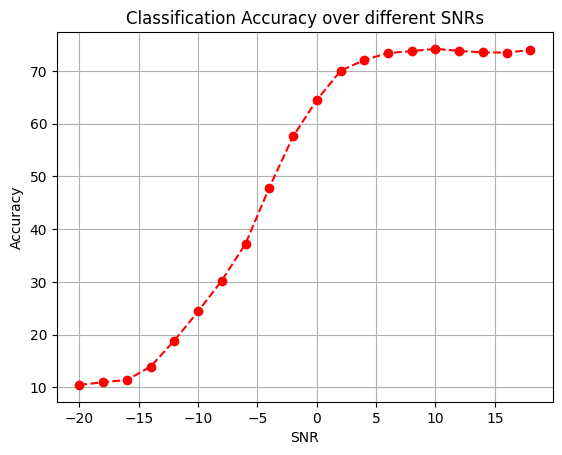

In [23]:
plot_results(y_pred_ann, y_test, snr_test)

In [24]:
print_results(y_pred_ann, y_test, snr_test)

,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
accuracy,10.48,10.99,11.42,13.95,18.88,24.4,30.26,37.25,47.87,57.57,64.45,69.99,72.05,73.36,73.74,74.15,73.78,73.48,73.47,73.91
